# Finding classification datasets fit for TSMD using Clustering
We aim to find classification datasets that can be used to create TSMD
benchmarks. A classification dataset can be used fit to creating TSMD time
series if the instances belonging to different classes are distinguishable in an
unsupervised manner. We assess this by applying a centroid-based clustering
algorithm ($k$-medoids) and observing whether a good clustering can be achieved.
We use TimeSeriesClassification (TSC) datasets with at least 5 classes ($c ≥ 5$).
The datasets can be categorized based on whether they are fixed-length or
variable-length and whether they are univariate or multivariate.
For the first category (fixed-length, univariate), We can use a recent clustering benchmark paper. We cluster the datasets from the remaining three categories ourselves.

All datasets are clustered with $k$-medoids because it can be applied for both Euclidean
distance (ED) and Dynamic Time Warping (DTW) distance (in contrast to $k$-means). All instances are $z$-normalized beforehand and $k = c$. To apply $k$-medoids with Euclidean distance on a variable-length dataset, I resample instances from the dataset such that their lengths are equal to the average length in the dataset. DTW is directly applicable. To apply $k$-medoids with DTW on a multivariate dataset, I use dependent DTW.

In [1]:
import os
PATH_TO_RESULTS = os.path.join(".", "cluster_results")

In [2]:
import numpy as np

import kmedoids
from sklearn.metrics import adjusted_rand_score
import dtaidistance.dtw_ndim as dtw
from tslearn.preprocessing import TimeSeriesResampler
from aeon.datasets import load_classification


import matplotlib.pyplot as plt
import pickle
import pandas as pd

/cw/dtaijupiter/NoCsBack/dtai/daanv/miniconda3/envs/tsmdeval/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [7]:
def ed(ts1, ts2):
    return dtw.distance(ts1, ts2, window=1, use_c=True)

def dtwdistance(ts1, ts2, **dtw_params):
    return dtw.distance(ts1, ts2, use_c=True, **dtw_params)

def distance_matrix(time_series, distance_fun):
    n = len(time_series)
    distance_matrix = np.full((n, n), np.inf)
    for i in range(n):
        for j in range(i, n):
            distance = distance_fun(time_series[i], time_series[j])
            distance_matrix[i, j] = distance_matrix[j, i] = distance
    return distance_matrix

In [8]:
def resample_ts(ts, length):
    resampled = TimeSeriesResampler(sz=length).transform(ts.T).T
    return resampled[0]

def znormalize(ts):
    ts = (ts - np.mean(ts, axis=None)) / np.std(ts, axis=None)
    return ts

In [9]:
# Datasets with more than 5 classes
FIX_LENGTH_MULTIVARIATE = ["ArticularyWordRecognition", "Cricket", "DuckDuckGeese", "EigenWorms", "Ering", "Handwriting", "Libras", "LSST", "NATOPS", "PenDigits", "PEMS-SF", "PhonemeSpectra", "UWaveGestureLibrary"]
VAR_LENGTH_UNIVARIATE   = ["AllGestureWiimoteX", "AllGestureWiimoteY", "AllGestureWiimoteZ", "GestureMidAirD1", "GestureMidAirD2", "GestureMidAirD3", "GesturePebbleZ1", "GesturePebbleZ2", "PickupGestureWiimoteZ", "PLAID", "ShakeGestureWiimoteZ"]
VAR_LENGTH_MULTIVARIATE = ['CharacterTrajectories', 'InsectWingbeat', 'JapaneseVowels', 'SpokenArabicDigits',]
DATASETS = FIX_LENGTH_MULTIVARIATE + VAR_LENGTH_UNIVARIATE + VAR_LENGTH_MULTIVARIATE

In [50]:
# TODO: remove this
import sys
sys.path.insert(0, "..")
import benchmark_generation

df_results = pd.DataFrame(columns=['dataset', 'distance_measure', 'ari'])

# for ds_name in DATASETS:
for ds_name in ["ArticularyWordRecognition", "AllGestureWiimoteX", "JapaneseVowels"]:
    print(ds_name)
    # Load the dataset
    X_train, y_train = load_classification(name=ds_name, split='train', load_equal_length=False)
    X_test, y_test = load_classification(name=ds_name, split='test', load_equal_length=False)

    df_train = benchmark_generation.convert_X_y_to_df(X_train, y_train)
    df_test = benchmark_generation.convert_X_y_to_df(X_test, y_test)

    # Combine, z-normalize, and resplit
    df = pd.concat((df_train, df_test)).reset_index(drop=True)
    df['ts'] = df['ts'].apply(znormalize)
    
    # Resample the dataset
    l_mean = int(df['length'].mean())
    df['resampled'] = df['ts'].apply(lambda instance: resample_ts(instance, l_mean))
    
    # Number of classes
    n_classes = len(np.unique(df['label']))

    # Cluster using DTW
    D = distance_matrix(df['ts'].tolist(), dtwdistance)
    np.random.seed(0)
    cluster_labels = kmedoids.fastpam1(D, n_classes).labels
    ari_dtw = adjusted_rand_score(df['label'].to_numpy(), cluster_labels)
    new_row = {'dataset': ds_name, 'distance_measure': "dtw", 'ari': ari_dtw}
    df_results = pd.concat((df_results, pd.DataFrame([new_row])), ignore_index=True)

    # Cluster using ED
    D = distance_matrix(df['ts'].tolist(), ed)
    np.random.seed(0)
    cluster_labels = kmedoids.fastpam1(D, n_classes).labels
    ari_ed = adjusted_rand_score(df['label'].to_numpy(), cluster_labels)
    new_row = {'dataset': ds_name, 'distance_measure': "ed", 'ari': ari_ed}
    df_results = pd.concat((df_results, pd.DataFrame([new_row])), ignore_index=True)

    # Average
    new_row = {'dataset': ds_name, 'distance_measure': "avg", 'ari': (ari_dtw + ari_ed) / 2.0}
    df_results = pd.concat((df_results, pd.DataFrame([new_row])), ignore_index=True)

ArticularyWordRecognition
AllGestureWiimoteX
JapaneseVowels


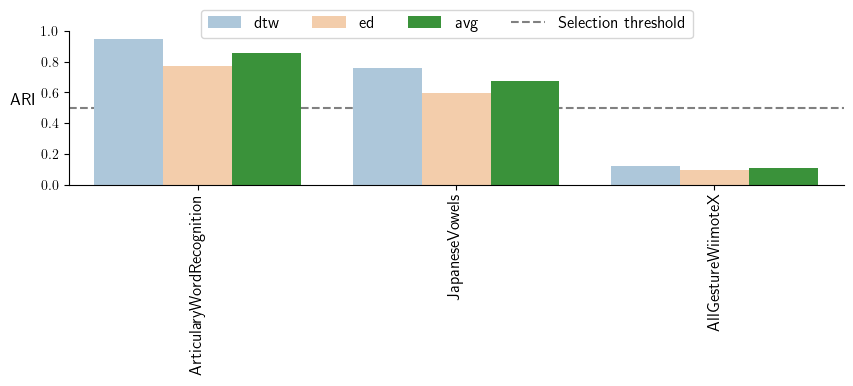

In [54]:
import matplotlib.pyplot as plt
FONT_SIZE = 12

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath}"
})
import seaborn as sns
# add 'average' as value to distance measure 

fig, ax = plt.subplots(figsize=(10, 2))

tab_colors = sns.color_palette("tab10")
def make_rgb_transparent(rgb, alpha, rgb_background=(1,1,1)):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, rgb_background)]

sns.barplot(ax=ax, x='dataset', y='ari', hue='distance_measure', data=df_results, legend=True, order=df_results[df_results['distance_measure'] == 'avg'].sort_values(by="ari")["dataset"].to_list()[::-1], palette=[make_rgb_transparent(tab_colors[0], 0.4), make_rgb_transparent(tab_colors[1], 0.4), tab_colors[2]])
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylim([0, 1])

l = ax.axhline(0.5, c='grey', zorder=-1, ls='--', label='Selection threshold', linewidth=1.5)
ax.legend(loc='lower left', bbox_to_anchor=(0.16, 0.9), ncol=4, fontsize=FONT_SIZE)
ax.set_ylabel("ARI", rotation=0, fontsize=FONT_SIZE, ha='right')
ax.set_xlabel(None)

plt.xticks(rotation=90, fontsize=FONT_SIZE)
plt.savefig("cluster_results.pdf", bbox_inches='tight')
plt.show()